# Wordle Suggestion Helper
Enter guesses in given format below and the programs prints the remaining possible words from the list of all possbile answers.

In [3]:
import re
import string
from collections import Counter
from random import choice

In [31]:
class WordleSuggetions:
    
    def __init__(self,file_name = 'wordle-answers-alphabetical.txt'):
        
        # Load all possible answers from file
        with open(file_name) as f:
            self.all_answers = f.read().upper().split('\n')
        
        # init class variables
        self.possible_sets = []
        self.guesses_results = {}
        self.required_letters = []
        self.remaining_words = self.all_answers
                
        # init possible sets of letters for each position in answer
        for i in range(5):
            tmp = ''
            for word in self.all_answers:
                if word[i] not in tmp:
                    tmp = tmp + word[i]
            self.possible_sets.append(set(tmp))
    
    def update_required_letters(self): 
        # collect letters words must contain
        required_letters = []
        for key in self.guesses_results:
            for result in zip(key,self.guesses_results[key]):
                if result[1] > 0:
                    required_letters.append(result[0])
        self.required_letters = set(required_letters)
        
    def update_sets(self):
        # Trim the posibility set
        for key in self.guesses_results.keys():
            for i,result in enumerate(zip(key,self.guesses_results[key])):
                if result[1] == 0:
                    # remove letter from all sets
                    self.possible_sets = [x-set(result[0]) for x in self.possible_sets]
                elif result[1] == 1:
                    # remove letter from location set
                    self.possible_sets[i] = self.possible_sets[i] - set(result[0])
                else:
                    # letter is correct so make set equal to letter in correct location
                    self.possible_sets[i] = set(result[0])

    def update_words(self):
        
        self.update_required_letters()
        
        # build regex from possible letter sets
        tester = ''
        for s in self.possible_sets:
            s = list(s)
            s.sort()
            s = ''.join(s)
            tester = tester + f'[{s}]'
        
        # find remaining words
        tmp = []
        for word in self.remaining_words:
            if self.required_letters.issubset(set(word)):
                if re.match(tester,word):
                    tmp.append(word)
        self.remaining_words = tmp
        
    def add_new_guess_and_result(self,word,result):
        ''' NOT_IN_WORD = 0
            IN_WORD = 1
            CORRECT = 2
        '''
        valid_input = (len(word) == 5) and (len(result)==5) and set(result).issubset(set([0,1,2,]))
        if not valid_input:
            raise Exception('Invalid Input, word must be 5 letters and results are length 5 with elements 0,1,2')
        self.guesses_results[word.upper()] = result
        
    def suggest_word_most_frequent_letter(self):  
        TOP_CUTOFF = 5
        tmp = []
        for word in self.remaining_words:
            tmp.append(list(set(word) - self.required_letters))
        most_freq_letters = Counter([x for y in tmp for x in y]).most_common(TOP_CUTOFF)
        most_freq_letters = [x[0] for x in most_freq_letters]
        
        suggestions = []
        for i in range(TOP_CUTOFF-1):
            for word in self.remaining_words:
                if set(most_freq_letters).issubset(set(word)):
                    suggestions.append(word)
            if suggestions:
                break
            else:
                most_freq_letters = most_freq_letters[:-1]
        
        if len(suggestions) > 1:
            # remove words with duplicate letters
            tmp = []
            for word in suggestions:
                if len(set(word)) > 4:
                    tmp.append(word)
            if tmp:
                suggestions = tmp
        if len(suggestions) > 1:
            return choice(suggestions)
        elif len(suggestions) == 1:
            return suggestions
        else:
            return choice(self.remaining_words)
            
    
    def suggest_word_that_eliminates_most_remaining(self):
        w = WordleSuggetions()
        w.guesses_results = self.guesses_results
            
    def print_suggestions(self):
        self.update_sets()
        self.update_words()
        
        print('='*20)
        print(f'{len(self.remaining_words)} of {len(self.all_answers)} Words Remaining:')
        print(self.remaining_words)
        print(f'\nSuggestion for next: {self.suggest_word_most_frequent_letter()}')

## Solve Puzzle

In [40]:
ws = WordleSuggetions()

''' Results are entered as list with values for each letter:
    NOT_IN_WORD = 0
    IN_WORD = 1
    CORRECT = 2
'''
ws.add_new_guess_and_result('RAISE',[0,0,0,0,0])
ws.add_new_guess_and_result('YOUNG',[0,2,2,0,0])
ws.add_new_guess_and_result('TOUCH',[0,2,2,1,0])

ws.print_suggestions()

1 of 2315 Words Remaining:
['COULD']

Suggestion for next: ['COULD']


In [37]:
words_remaining = [2315,168,9,1]

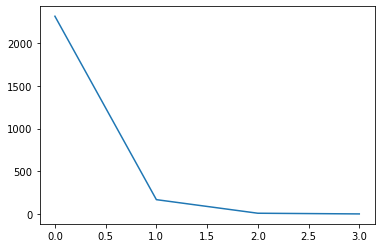

In [39]:
import matplotlib.pyplot as plt
tries = [i for i in range(4)]
plt.plot(tries,words_remaining)